In [1]:
# Reads and closes file before returning the content as a string
def read_file(fileName):
    file = open(fileName)
    fileContent = file.read()
    file.close()
    return fileContent

# Separates the inputted content into 4 lists of metrics (4 since we know that these metrics are always outputted)
def separate_metrics(fileString, ping_data = [], rss_data = [], route_data = [], link_data = []):
    fileString = remove_separations(fileString)

    # Split into lists of data
    for index, content in enumerate(fileString):
        if(index % 4 == 0):
            ping_data.append(content) 
        elif(index % 4 == 1):
            rss_data.append(content)
        elif(index % 4 == 2):
            route_data.append(content)
        elif(index % 4 == 3):
            link_data.append(content)

    return ping_data, rss_data, route_data, link_data

# Removes the redundant separations that are purely for visual assistance
def remove_separations(fileString):
    fileString = remove_occurrences(fileString, "________________________________________________________________")
    fileString = remove_occurrences(fileString, "____________________________START_______________________________")
    fileString = remove_occurrences(fileString, "___________________________END__________________________________")
    fileString = remove_occurrences(fileString, "")
    return fileString

# Removes all occurences of a given item in a string
def remove_occurrences(fileString, item):
    res = [i for i in fileString if i != item]
    return res

# Extract packet loss, average rtt and the standard deviation of the rtt from the list of ping data
def read_ping_data(ping_data, packet_loss_list = [], avg_rtt_list = [], std_deviation_rtt = []):
    for entry in ping_data:
        ping_information = entry.split("---")[2]
        split_information = ping_information.split(",")
        packet_loss_list.append(split_information[2].split("%")[0])
        avg_rtt_list.append(split_information[3].split("/")[4])
        std_deviation_rtt.append(split_information[3].split("/")[6][:-3])

    return packet_loss_list, avg_rtt_list, std_deviation_rtt

# Extract RSS and average RSS from the list of RSS data
def read_rss_data(rss_data, rss_list = [], rss_avg_list = []):
    for entry in rss_data:
        rss_list.append(find_between(entry, "signal: ", "["))
        rss_avg_list.append(find_between(entry, "signal avg: ", "["))

    return rss_list, rss_avg_list

# Finds and returns the string between two given sequences of strings
def find_between(s, first, last):
    start = s.index(first)+len(first)
    end = s.index(last, start)
    return s[start:end]

# Turns a list of strings into a list of floats
def list_string_to_float(stringList):
    floatList = [float(x) for x in stringList]
    return floatList

# Turns a list of strings into a list of floats
def list_string_to_int(stringList):
    intList = [int(x) for x in stringList]
    return intList

# Returns the average of a list
def list_average(list):
    return (sum(list) / len(list))


def split_iperf(iperfString, iperf_output_list = []):
    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()
    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")
        server_client_edited_list = []
        str_to_find = "- - - - - - - - - - - - - - - - - - - - - - - - -"
        for s_c_entry in server_client_list:
            s_c_entry = s_c_entry[s_c_entry.find(str_to_find)+len(str_to_find)+1:]
            server_client_edited_list.append(s_c_entry)
        iperf_output_list.append(server_client_edited_list)

    return iperf_output_list

# Extracts iperf into a list of lists in the following format:
# Index 0 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# Index 1 (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
# Index 2 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# ...
# Index n (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
def extract_iperf(iperf_list):
    s_c_entry_list = []
    for s_c_entry in iperf_list:
        entry_list = []
        for entry in s_c_entry:
            entry_list = []
            time_taken = find_between(entry, "-", "sec").strip()
            entry_list.append(time_taken)
            bits_transferred = find_between(entry, "sec", "MBytes").strip()
            entry_list.append(bits_transferred)
            transfer_rate = find_between(entry, "MBytes", "Mbits/sec").strip()
            entry_list.append(transfer_rate)
            if "Retr" in entry:
                retry_number = find_between(entry, "/sec", "sender").strip()
                entry_list.append(retry_number)
            s_c_entry_list.append(entry_list)
    return s_c_entry_list

In [2]:
content = read_file("../results.txt")
split_content = content.split("\n")
ping_data, rss_data, route_data, link_data = separate_metrics(split_content)
packet_loss_list, avg_rtt_list, std_deviation_rtt = read_ping_data(ping_data)
rss_list, rss_avg_list = read_rss_data(rss_data)

iperfContent = read_file("../iperf_results.txt")
iperf_output_list = split_iperf(iperfContent)
test = extract_iperf(iperf_output_list)

# TODO: Still missing extraction of LINK and ROUTE metrics 
# I am not sure what is important in these measurements, so figure this out. In route the routing metric is probably important/interesting to look at
#
# Answer: Routing protocol metric might be interesting to look at. The stale metric from Link. And the p metric from route.


# TODO: How should we do the plotting of different experiments within one experiment? 
# Should we just average the measurements across the list of data measurements from each experiment and then plot these averages against each other?
#
# Answer: Attempt to use the full range of measurements across one experiment and then color code according to experiment.

Text(0, 0.5, 'Average RSS value')

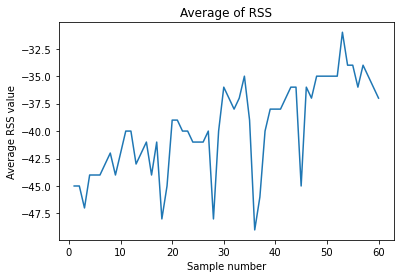

In [3]:
import matplotlib.pyplot as plt

######### Prepare lists by turning them into floats/ints instead of strings######
# Int
rss_list = list_string_to_int(rss_list)
rss_avg_list = list_string_to_int(rss_avg_list)

# Float
avg_rtt_list = list_string_to_float(avg_rtt_list)
std_deviation_rtt = list_string_to_float(std_deviation_rtt)
packet_loss_list = list_string_to_float(packet_loss_list)
#################################################################################

# Example of plotting
x_axis = list(range(1, len(rss_avg_list)+1))
fig_avg_rss, axis_avg_rss = plt.subplots()
axis_avg_rss.plot(x_axis, rss_avg_list)
axis_avg_rss.set_title("Average of RSS")
axis_avg_rss.set_xlabel("Sample number")
axis_avg_rss.set_ylabel("Average RSS value")